In [50]:
# supress warnings
import warnings
warnings.filterwarnings('ignore')

# Importing all required packages
import numpy as np
import pandas as pd

# Data viz lib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from matplotlib.pyplot import xticks

In [51]:
dtafile = 'HCMST 2017 fresh sample for public sharing draft v1.1.dta'

df = pd.read_stata(dtafile)
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3510 entries, 0 to 3509
Columns: 285 entries, CaseID to subject_yrsed
dtypes: category(243), float32(20), float64(18), int16(2), int32(1), int8(1)
memory usage: 1.7 MB


In [52]:
df['age_bin'] = pd.cut(df['ppage'], [0, 20, 30, 40, 50, 60, 70, 80, 90, 100], 
                              labels=['0-20', '20-30', '30-40', '40-50','50-60','60-70','70-80', '80-90','90-100'])
df= df.drop('ppage',axis = 1)

df = df.drop(['CASEID_NEW', 'weight1', 'weight1_freqwt', 'weight2', 'weight1a', 'weight1a_freqwt', 'weight_combo', 'weight_combo_freqwt'], axis=1)


# filling with most common class
df = df.apply(lambda x: x.fillna(x.value_counts().index[0]))
df

,CaseID,qflag,duration,speed_flag,consent,xlgb,S1,S2,S3,DOV_Branch,...,hcm2017q24_met_through_friend,hcm2017q24_met_through_as_nghbrs,hcm2017q24_met_as_through_cowork,w6_subject_race,interracial_5cat,partner_mother_yrsed,subject_mother_yrsed,partner_yrsed,subject_yrsed,age_bin
0,2,Qualified,9,Completed survey in over 2 minutes,"Yes, I agree to participate",LGB sample,"No, I am not Married","No, I am single, with no boyfriend, no girlfri...",Yes,2,...,no,no,no,White,no,12.0,14.0,12.0,14.0,20-30
1,3,Qualified,11,Completed survey in over 2 minutes,"Yes, I agree to participate",gen pop,"Yes, I am Married","Yes, I have a sexual partner (boyfriend or gir...",Yes,1,...,no,no,yes,White,no,12.0,16.0,17.0,17.0,50-60
2,5,Qualified,7,Completed survey in over 2 minutes,"Yes, I agree to participate",gen pop,"Yes, I am Married","Yes, I have a sexual partner (boyfriend or gir...",Yes,1,...,no,no,no,White,no,9.0,7.5,14.0,17.0,40-50
3,6,Qualified,5,Completed survey in over 2 minutes,"Yes, I agree to participate",gen pop,"No, I am not Married","No, I am single, with no boyfriend, no girlfri...",Yes,2,...,no,no,no,White,no,16.0,12.0,12.0,12.0,20-30
4,7,Qualified,13,Completed survey in over 2 minutes,"Yes, I agree to participate",gen pop,"Yes, I am Married","Yes, I have a sexual partner (boyfriend or gir...",Yes,1,...,no,yes,no,White,no,14.0,17.0,16.0,16.0,50-60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3505,4304,Qualified,5,Completed survey in over 2 minutes,"Yes, I agree to participate",LGB sample,"Yes, I am Married","Yes, I have a sexual partner (boyfriend or gir...",Yes,1,...,no,no,no,White,no,12.0,12.0,16.0,17.0,20-30
3506,4305,Qualified,3,Completed survey in over 2 minutes,"Yes, I agree to participate",LGB sample,"No, I am not Married",I have a romantic partner who is not yet a sex...,Yes,1,...,yes,no,no,White,no,16.0,17.0,16.0,16.0,20-30
3507,4307,Qualified,8,Completed survey in over 2 minutes,"Yes, I agree to participate",LGB sample,"Yes, I am Married","Yes, I have a sexual partner (boyfriend or gir...",Yes,1,...,no,no,no,White,yes,14.0,16.0,16.0,16.0,40-50
3508,4309,Qualified,7,Completed survey in over 2 minutes,"Yes, I agree to participate",LGB sample,"No, I am not Married","Yes, I have a sexual partner (boyfriend or gir...",Yes,1,...,no,no,no,White,yes,12.0,13.0,17.0,17.0,30-40


In [53]:
df.isnull().sum()*100/df.shape[0]

df = df.astype(str)

In [54]:
# First we will keep a copy of data
bank_cust_copy = df.copy()


In [55]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
bank_cust = df.apply(le.fit_transform)
bank_cust.head()

,CaseID,qflag,duration,speed_flag,consent,xlgb,S1,S2,S3,DOV_Branch,...,hcm2017q24_met_through_friend,hcm2017q24_met_through_as_nghbrs,hcm2017q24_met_as_through_cowork,w6_subject_race,interracial_5cat,partner_mother_yrsed,subject_mother_yrsed,partner_yrsed,subject_yrsed,age_bin
0,913,1,338,0,0,0,0,1,1,1,...,0,0,0,4,0,3,5,3,5,1
1,1826,1,16,0,0,1,1,2,1,0,...,0,0,1,4,0,3,6,7,7,4
2,3039,1,297,0,0,1,1,2,1,0,...,0,0,0,4,0,12,11,5,7,3
3,3132,1,246,0,0,1,0,1,1,1,...,0,0,0,4,0,6,3,3,3,1
4,3226,1,46,0,0,1,1,2,1,0,...,0,1,0,4,0,5,7,6,6,4


In [56]:
from kmodes.kmodes import KModes

In [57]:
km_cao = KModes(n_clusters=2, init = "Cao", n_init = 1, verbose=1)
fitClusters_cao = km_cao.fit_predict(bank_cust)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 314, cost: 225953.0
Run 1, iteration: 2/100, moves: 295, cost: 225439.0
Run 1, iteration: 3/100, moves: 25, cost: 225439.0


In [58]:
fitClusters_cao

array([0, 0, 0, ..., 0, 1, 0], dtype=uint16)

In [59]:
clusterCentroidsDf = pd.DataFrame(km_cao.cluster_centroids_)
clusterCentroidsDf.columns = bank_cust.columns

In [60]:
# Mode of the clusters
clusterCentroidsDf

,CaseID,qflag,duration,speed_flag,consent,xlgb,S1,S2,S3,DOV_Branch,...,hcm2017q24_met_through_friend,hcm2017q24_met_through_as_nghbrs,hcm2017q24_met_as_through_cowork,w6_subject_race,interracial_5cat,partner_mother_yrsed,subject_mother_yrsed,partner_yrsed,subject_yrsed,age_bin
0,0,1,297,0,0,1,1,2,1,0,...,0,0,0,4,0,3,3,3,3,4
1,36,1,338,0,0,1,0,2,1,0,...,0,0,0,4,0,3,4,4,4,1


In [61]:
km_huang = KModes(n_clusters=2, init = "Huang", n_init = 1, verbose=1)
fitClusters_huang = km_huang.fit_predict(bank_cust)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 809, cost: 223318.0
Run 1, iteration: 2/100, moves: 299, cost: 223203.0
Run 1, iteration: 3/100, moves: 13, cost: 223202.0
Run 1, iteration: 4/100, moves: 0, cost: 223202.0


In [62]:
# Predicted clusters
fitClusters_huang

array([1, 1, 0, ..., 0, 0, 1], dtype=uint16)

In [63]:
cost = []
for num_clusters in list(range(1,10)):
    kmode = KModes(n_clusters=num_clusters, init = "Cao", n_init = 1, verbose=1)
    kmode.fit_predict(bank_cust)
    cost.append(kmode.cost_)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 229951.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 314, cost: 225953.0
Run 1, iteration: 2/100, moves: 295, cost: 225439.0
Run 1, iteration: 3/100, moves: 25, cost: 225439.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 541, cost: 222656.0
Run 1, iteration: 2/100, moves: 461, cost: 221685.0
Run 1, iteration: 3/100, moves: 393, cost: 221066.0
Run 1, iteration: 4/100, moves: 109, cost: 221032.0
Run 1, iteration: 5/100, moves: 1, cost: 221032.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 830, cost: 220015.0
Run 1, iteration: 2/100, moves: 550, cost: 218710.0
Run 1, iteration: 3/100, moves: 376, cost: 218112.0
Run 1, iteration: 4/100, moves: 250, cost: 218055.0
Run 1, it

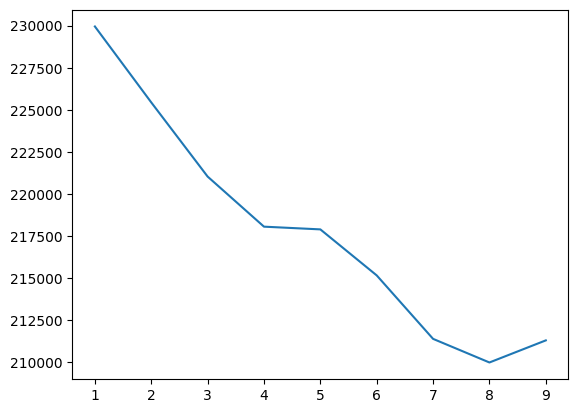

In [66]:
y = np.array([i for i in range(1,10,1)])
plt.plot(y,cost)

In [68]:
km_cao = KModes(n_clusters=8, init = "Cao", n_init = 1, verbose=1)
fitClusters_cao = km_cao.fit_predict(bank_cust)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 1154, cost: 214532.0
Run 1, iteration: 2/100, moves: 1031, cost: 212514.0
Run 1, iteration: 3/100, moves: 328, cost: 211879.0
Run 1, iteration: 4/100, moves: 342, cost: 211052.0
Run 1, iteration: 5/100, moves: 408, cost: 209991.0
Run 1, iteration: 6/100, moves: 238, cost: 209984.0
Run 1, iteration: 7/100, moves: 0, cost: 209984.0


In [70]:
bank_cust = bank_cust_copy.reset_index()
clustersDf = pd.DataFrame(fitClusters_cao)
clustersDf.columns = ['cluster_predicted']
combinedDf = pd.concat([bank_cust, clustersDf], axis = 1).reset_index()
combinedDf = combinedDf.drop(['index', 'level_0'], axis = 1)

In [71]:
combinedDf.head()

,CaseID,qflag,duration,speed_flag,consent,xlgb,S1,S2,S3,DOV_Branch,...,hcm2017q24_met_through_as_nghbrs,hcm2017q24_met_as_through_cowork,w6_subject_race,interracial_5cat,partner_mother_yrsed,subject_mother_yrsed,partner_yrsed,subject_yrsed,age_bin,cluster_predicted
0,2,Qualified,9,Completed survey in over 2 minutes,"Yes, I agree to participate",LGB sample,"No, I am not Married","No, I am single, with no boyfriend, no girlfri...",Yes,2,...,no,no,White,no,12.0,14.0,12.0,14.0,20-30,6
1,3,Qualified,11,Completed survey in over 2 minutes,"Yes, I agree to participate",gen pop,"Yes, I am Married","Yes, I have a sexual partner (boyfriend or gir...",Yes,1,...,no,yes,White,no,12.0,16.0,17.0,17.0,50-60,0
2,5,Qualified,7,Completed survey in over 2 minutes,"Yes, I agree to participate",gen pop,"Yes, I am Married","Yes, I have a sexual partner (boyfriend or gir...",Yes,1,...,no,no,White,no,9.0,7.5,14.0,17.0,40-50,5
3,6,Qualified,5,Completed survey in over 2 minutes,"Yes, I agree to participate",gen pop,"No, I am not Married","No, I am single, with no boyfriend, no girlfri...",Yes,2,...,no,no,White,no,16.0,12.0,12.0,12.0,20-30,6
4,7,Qualified,13,Completed survey in over 2 minutes,"Yes, I agree to participate",gen pop,"Yes, I am Married","Yes, I have a sexual partner (boyfriend or gir...",Yes,1,...,yes,no,White,no,14.0,17.0,16.0,16.0,50-60,5


In [73]:
cluster_0 = combinedDf[combinedDf['cluster_predicted'] == 0]
cluster_1 = combinedDf[combinedDf['cluster_predicted'] == 1]
cluster_2 = combinedDf[combinedDf['cluster_predicted'] == 2]
cluster_3 = combinedDf[combinedDf['cluster_predicted'] == 3]
cluster_4 = combinedDf[combinedDf['cluster_predicted'] == 4]
cluster_5 = combinedDf[combinedDf['cluster_predicted'] == 5]
cluster_6 = combinedDf[combinedDf['cluster_predicted'] == 6]
cluster_7 = combinedDf[combinedDf['cluster_predicted'] == 7]
cluster_8 = combinedDf[combinedDf['cluster_predicted'] == 8]

## Cluster infos

In [74]:
cluster_0.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1007 entries, 1 to 3509
Columns: 278 entries, CaseID to cluster_predicted
dtypes: object(277), uint16(1)
memory usage: 2.1+ MB


In [75]:
cluster_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 221 entries, 19 to 3508
Columns: 278 entries, CaseID to cluster_predicted
dtypes: object(277), uint16(1)
memory usage: 480.4+ KB


In [76]:
cluster_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 239 entries, 15 to 3506
Columns: 278 entries, CaseID to cluster_predicted
dtypes: object(277), uint16(1)
memory usage: 519.5+ KB


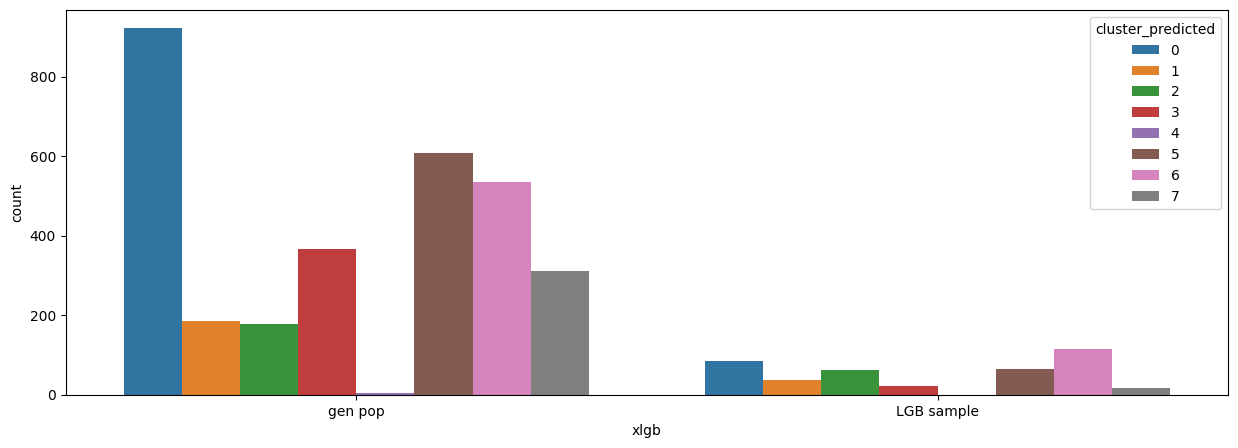

In [83]:
# pop analysis
plt.subplots(figsize = (15,5))
sns.countplot(x=combinedDf['xlgb'],order=combinedDf['xlgb'].value_counts().index,hue=combinedDf['cluster_predicted'])
plt.show()

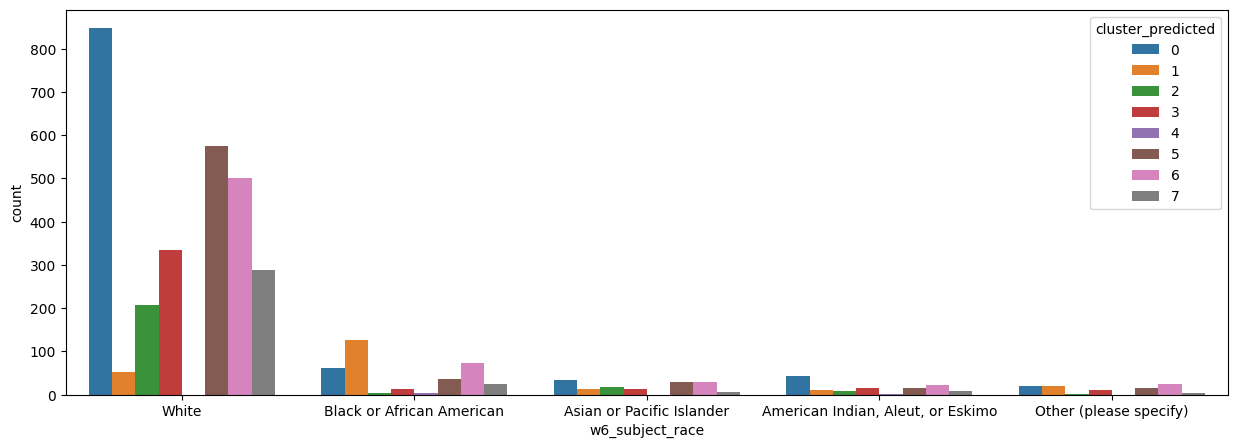

In [84]:
# race analysis
plt.subplots(figsize = (15,5))
sns.countplot(x=combinedDf['w6_subject_race'],order=combinedDf['w6_subject_race'].value_counts().index,hue=combinedDf['cluster_predicted'])
plt.show()

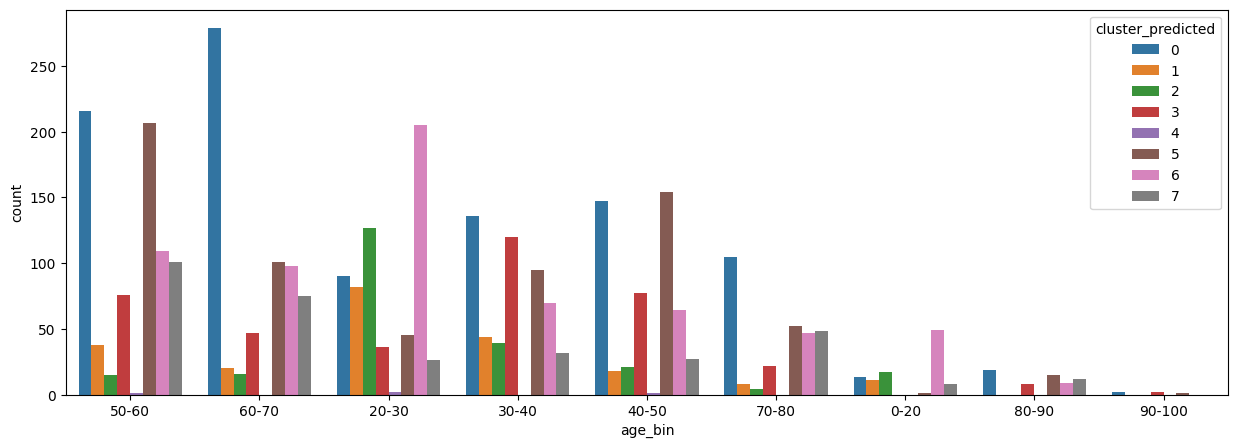

In [92]:
# race analysis
plt.subplots(figsize = (15,5))
sns.countplot(x=combinedDf['age_bin'],order=combinedDf['age_bin'].value_counts().index,hue=combinedDf['cluster_predicted'])
plt.show()

In [102]:
combinedDf.head()

,CaseID,qflag,duration,speed_flag,consent,xlgb,S1,S2,S3,DOV_Branch,...,hcm2017q24_met_through_as_nghbrs,hcm2017q24_met_as_through_cowork,w6_subject_race,interracial_5cat,partner_mother_yrsed,subject_mother_yrsed,partner_yrsed,subject_yrsed,age_bin,cluster_predicted
0,2,Qualified,9,Completed survey in over 2 minutes,"Yes, I agree to participate",LGB sample,"No, I am not Married","No, I am single, with no boyfriend, no girlfri...",Yes,2,...,no,no,White,no,12.0,14.0,12.0,14.0,20-30,6
1,3,Qualified,11,Completed survey in over 2 minutes,"Yes, I agree to participate",gen pop,"Yes, I am Married","Yes, I have a sexual partner (boyfriend or gir...",Yes,1,...,no,yes,White,no,12.0,16.0,17.0,17.0,50-60,0
2,5,Qualified,7,Completed survey in over 2 minutes,"Yes, I agree to participate",gen pop,"Yes, I am Married","Yes, I have a sexual partner (boyfriend or gir...",Yes,1,...,no,no,White,no,9.0,7.5,14.0,17.0,40-50,5
3,6,Qualified,5,Completed survey in over 2 minutes,"Yes, I agree to participate",gen pop,"No, I am not Married","No, I am single, with no boyfriend, no girlfri...",Yes,2,...,no,no,White,no,16.0,12.0,12.0,12.0,20-30,6
4,7,Qualified,13,Completed survey in over 2 minutes,"Yes, I agree to participate",gen pop,"Yes, I am Married","Yes, I have a sexual partner (boyfriend or gir...",Yes,1,...,yes,no,White,no,14.0,17.0,16.0,16.0,50-60,5


In [107]:
from sklearn import model_selection, preprocessing, feature_selection, ensemble, linear_model, metrics, decomposition
X = combinedDf.drop("cluster_predicted", axis=1).values
y = combinedDf["cluster_predicted"].values
feature_names = combinedDf.drop("cluster_predicted", axis=1).columns.tolist()
## Importance
model = ensemble.RandomForestClassifier(n_estimators=100,
                      criterion="entropy", random_state=0)
model.fit(X,y)
importances = model.feature_importances_
## Put in a pandas combinedDf
combinedDf_importances = pd.DataFrame({"IMPORTANCE":importances, 
            "VARIABLE":feature_names}).sort_values("IMPORTANCE", 
            ascending=False)
combinedDf_importances['cumsum'] = combinedDf_importances['IMPORTANCE'].cumsum(axis=0)
combinedDf_importances = combinedDf_importances.set_index("VARIABLE")
    
## Plot
fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False)
fig.suptitle("Features Importance", fontsize=20)
ax[0].title.set_text('variables')
combinedDf_importances[["IMPORTANCE"]].sort_values(by="IMPORTANCE").plot(kind="barh", legend=False, ax=ax[0]).grid(axis="x")
ax[0].set(ylabel="")
ax[1].title.set_text('cumulative')
combinedDf_importances[["cumsum"]].plot(kind="line", linewidth=4, legend=False, ax=ax[1])
ax[1].set(xlabel="", xticks=np.arange(len(combinedDf_importances)), xticklabels=combinedDf_importances.index)
plt.xticks(rotation=70)
plt.grid(axis='both')
plt.show()

ValueError: could not convert string to float: 'Qualified'